## feature selection

In [1]:
print("hi")

hi


In [6]:
import glob,os
import pandas as pd
folder_path = r"C:\Users\saxen\OneDrive\Desktop\School\Repo\SchoolPython\PrinciplesOfML\Module8\data"
all_files = glob.glob(os.path.join(folder_path,"*.csv"))
dfs = []

for filename in all_files:
    print(filename)
    df = pd.read_csv(filename)
    dfs.append(df)
    
selected_columns = ['temperature_min', 'temperature_max', 'temperature_avg', 'precipitation']
features_df = pd.concat([df[selected_columns] for df in dfs], ignore_index=True)

C:\Users\saxen\OneDrive\Desktop\School\Repo\SchoolPython\PrinciplesOfML\Module8\data\historical_weather_data_20140901_20141001.csv
C:\Users\saxen\OneDrive\Desktop\School\Repo\SchoolPython\PrinciplesOfML\Module8\data\historical_weather_data_20140902_20141002.csv
C:\Users\saxen\OneDrive\Desktop\School\Repo\SchoolPython\PrinciplesOfML\Module8\data\historical_weather_data_20141002_20141101.csv
C:\Users\saxen\OneDrive\Desktop\School\Repo\SchoolPython\PrinciplesOfML\Module8\data\historical_weather_data_20141003_20141102.csv
C:\Users\saxen\OneDrive\Desktop\School\Repo\SchoolPython\PrinciplesOfML\Module8\data\historical_weather_data_20141102_20141202.csv
C:\Users\saxen\OneDrive\Desktop\School\Repo\SchoolPython\PrinciplesOfML\Module8\data\historical_weather_data_20141103_20141203.csv
C:\Users\saxen\OneDrive\Desktop\School\Repo\SchoolPython\PrinciplesOfML\Module8\data\historical_weather_data_20141203_20150102.csv
C:\Users\saxen\OneDrive\Desktop\School\Repo\SchoolPython\PrinciplesOfML\Module8\dat

## Elbow method to find optimal K- value

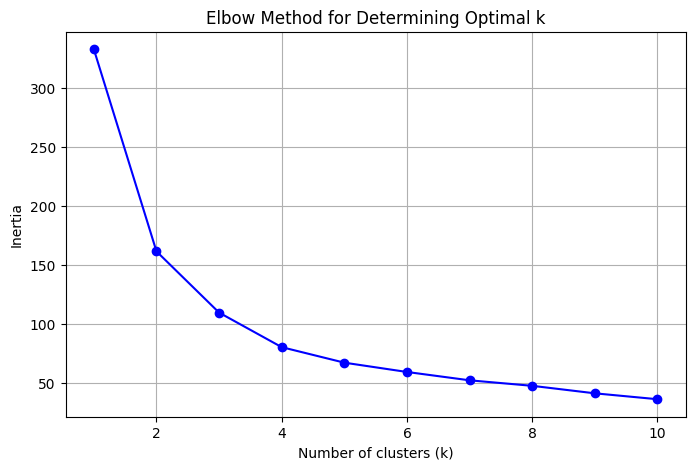

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt



# Select relevant features
features = features_df[['temperature_min', 'temperature_max', 'temperature_avg', 'precipitation']]

# Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)

# Determine the optimal number of clusters using the Elbow method
inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow method
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Determining Optimal k')
plt.grid(True)
plt.show()


## Apply K-Means Clustering

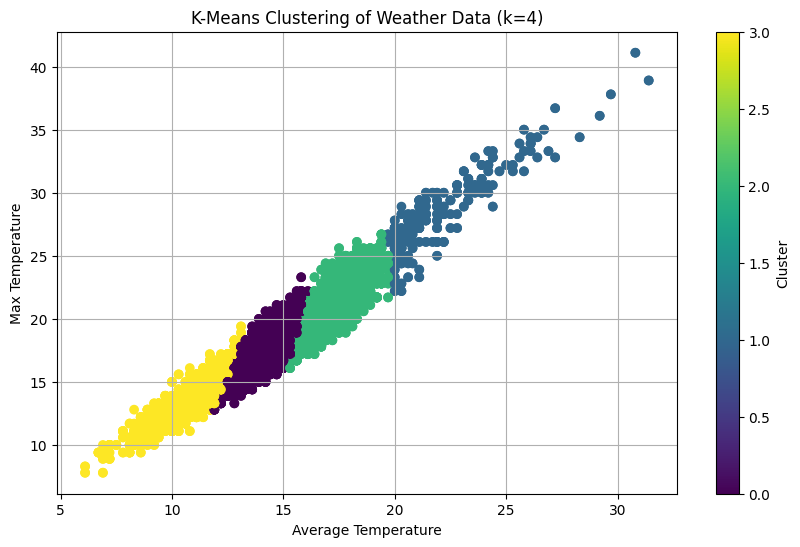

,temperature_min,temperature_max,temperature_avg,precipitation
0,11.075961,17.131694,14.102771,1.804745
1,15.913913,28.796232,22.354493,0.051594
2,13.468306,20.710023,17.088677,0.397912
3,8.035517,13.701220,10.870392,2.732177


In [5]:
# Apply K-Means clustering with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(normalized_features)

data = features_df

# Add cluster labels to the original data
data['cluster'] = clusters

# Visualize the clusters using a scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['temperature_avg'], data['temperature_max'], c=data['cluster'], cmap='viridis')
plt.xlabel('Average Temperature')
plt.ylabel('Max Temperature')
plt.title('K-Means Clustering of Weather Data (k=4)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

# Display cluster centers
centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(centers, columns=['temperature_min', 'temperature_max', 'temperature_avg', 'precipitation'])
cluster_centers_df


## Building the usage API

In [14]:
#from openai import OpenAI
import requests
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import numpy as np
from azure.core.credentials import AzureKeyCredential
from azure.maps.search import MapsSearchClient

SUBSCRIPTION_KEY = '6Hk0BuzXAh248HIBaBisjFdj0Y7bi97o09bOZMSyakK7IVyu9zSLJQQJ99AGAC8vTInLFAINAAAgAZMP9xmM'  # Replace with your actual subscription key
#openai.api_key = 'dsadsfds'

#client = OpenAI(
#  api_key='ssadadad'  # this is also the default, it can be omitted
#)

def search_address(query):
    maps_search_client = MapsSearchClient(credential=AzureKeyCredential(SUBSCRIPTION_KEY))
    result = maps_search_client.search_address(query=query)
    if len(result.results) > 0:
        lat = result.results[0].position.lat
        lon = result.results[0].position.lon
        print(f"Coordinate: {lat}, {lon}")
        return lat, lon
    else:
        print("No address found")
        return None, None

def fetch_weather_data(lat, lon, start_date, end_date):
    params = {
        'api-version': '1.1',
        'query': f"{lat},{lon}",
        'startDate': start_date.strftime('%Y-%m-%d'),
        'endDate': end_date.strftime('%Y-%m-%d'),
        'subscription-key': SUBSCRIPTION_KEY,
    }
    max_retries = 10
    retry_count = 0
    while retry_count < max_retries:
        try:
            response = requests.get("https://atlas.microsoft.com/weather/historical/actuals/daily/json", params=params)
            if response.status_code == 200:
                data = response.json()
                print(f"Fetched data for {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
                return data
            else:
                print(f"Error fetching data: {response.status_code}, {response.text}")
                retry_count += 1
                if retry_count < max_retries:
                    print(f"Retry attempt {retry_count} in 10 seconds...")
                    time.sleep(10)  # Wait for 10 seconds before retrying
                else:
                    print(f"Failed to fetch data after {max_retries} retries. Skipping this date range.")
                    return None
        except requests.exceptions.ConnectionError as e:
            print(f"ConnectionError: {e}. Retrying...")
            retry_count += 1
            if retry_count < max_retries:
                print(f"Retry attempt {retry_count} in 10 seconds...")
                time.sleep(10)  # Wait for 10 seconds before retrying
            else:
                print(f"Failed to fetch data after {max_retries} retries. Skipping this date range.")
                return None
    
    return None

def preprocess_data_old(raw_data, location_name):
    processed_data = []
    for day_data in raw_data['results']:
        processed_data.append({
            'location_name': location_name,
            'timestamp': datetime.strptime(day_data['date'], '%Y-%m-%dT%H:%M:%S%z'),  # Convert date string to datetime object
            'temperature_min': day_data['temperature']['minimum']['value'],
            'temperature_max': day_data['temperature']['maximum']['value'],
            'temperature_avg': day_data['temperature']['average']['value'],
            'precipitation': day_data['precipitation']['value'],
            'snowfall': day_data['snowfall']['value'],
            'snow_depth': day_data['snowDepth']['value'],
            'heating_degree_days': day_data['degreeDaySummary']['heating']['value'],
            'cooling_degree_days': day_data['degreeDaySummary']['cooling']['value']
        })
    df = pd.DataFrame(processed_data)
    return df

from datetime import datetime
import pandas as pd

def preprocess_data(raw_data, location_name):
    processed_data = []
    for day_data in raw_data['results']:
        try:
            processed_data.append({
                'location_name': location_name,
                'timestamp': datetime.strptime(day_data['date'], '%Y-%m-%dT%H:%M:%S%z'),  # Convert date string to datetime object
                'temperature_min': day_data['temperature']['minimum']['value'],
                'temperature_max': day_data['temperature']['maximum']['value'],
                'temperature_avg': day_data['temperature']['average']['value'],
                'precipitation': day_data['precipitation']['value'],
                'snowfall': day_data['snowfall']['value'],
                'snow_depth': day_data['snowDepth']['value'],
                'heating_degree_days': day_data['degreeDaySummary']['heating']['value'],
                'cooling_degree_days': day_data['degreeDaySummary']['cooling']['value']
            })
        except KeyError as e:
            # Handle missing keys by marking them as -1
            processed_data.append({
                'location_name': location_name,
                'timestamp': datetime.strptime(day_data['date'], '%Y-%m-%dT%H:%M:%S%z'),
                'temperature_min': day_data['temperature']['minimum'].get('value', -1),
                'temperature_max': day_data['temperature']['maximum'].get('value', -1),
                'temperature_avg': day_data['temperature']['average'].get('value', -1),
                'precipitation': day_data['precipitation'].get('value', -1),
                'snowfall': day_data.get('snowfall', {}).get('value', -1),
                'snow_depth': day_data.get('snowDepth', {}).get('value', -1),
                'heating_degree_days': day_data['degreeDaySummary'].get('heating', {}).get('value', -1),
                'cooling_degree_days': day_data['degreeDaySummary'].get('cooling', {}).get('value', -1)
            })
    
    df = pd.DataFrame(processed_data)
    return df


def get_real_time_weather(lat, lon,location):
    if lat and lon:
        end_date = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0) - timedelta(days=0)
        start_date = end_date  # same date
        raw_data = fetch_weather_data(lat, lon, start_date, end_date)
        if raw_data:
            weather_df = preprocess_data(raw_data, location)
    return weather_df[selected_columns]

def get_advice(cluster):
    advice = {
        0: "Prepare for a wet day with moderate temperatures. Don't forget your umbrella!", 
        1: "Expect moderate temperatures with little rain. A light jacket would be advisable.",
        2: "Expect a hot day with minimal or no rain",
        3: "Its gonna be a wet and cold day. Get ready for rain coat"    
    }
    return advice[cluster]

#def respond_to_query(query, city, weather_advice):
#    prompt = f"The user asked: {query}. Provide advice based on current weather conditions in {city}.\n\n{weather_advice}"
#    response = openai.Completion.create(
#        engine="text-davinci-003",
#        prompt=prompt,
#        max_tokens=150
#    )
#    
#    return response.choices[0].text.strip()
#
#def respond_to_query(query, city, weather_advice):
#    messages = [
#        {"role": "system", "content": f"Provide advice based on current weather conditions in {city}."},
#        {"role": "user", "content": query},
#        {"role": "assistant", "content": weather_advice}
#    ]
#    response = openai.ChatCompletion.create(
#        model="gpt-3.5-turbo",
#        messages=messages,
#        max_tokens=150
#    )
    
#    return response.choices[0].message['content'].strip()

import spacy

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

def respond_to_query(query, city, weather_advice):
    # Process the query using spaCy
    doc = nlp(query)

    # Construct the response based on the query and weather advice
    system_message = f"Provide advice based on current weather conditions in {city}."
    user_message = query
    assistant_message = weather_advice

    # Combine messages into a formatted response
    response = f"{system_message}\nUser: {user_message}\nAssistant: {assistant_message}"

    return response

# Define a list of trails with their suitable conditions
trails = [
    {
        'name': 'Sunnyvale Bay Trail',
        'min_temp': 10,
        'max_temp': 30,
        'max_precipitation': 1,
        'description': 'A scenic trail along the bay with moderate difficulty.'
    },
    {
        'name': 'Mission Peak Trail',
        'min_temp': 15,
        'max_temp': 25,
        'max_precipitation': 0.5,
        'description': 'A challenging hike with a great view from the top.'
    },
    {
        'name': 'Alum Rock Park',
        'min_temp': 12,
        'max_temp': 28,
        'max_precipitation': 2,
        'description': 'A family-friendly trail with picnic areas and wildlife.'
    }
]

# Function to recommend trails based on weather conditions
def recommend_trails(temperature_avg, precipitation):
    recommended_trails = []
    for trail in trails:
        if (trail['min_temp'] <= temperature_avg <= trail['max_temp']) and (precipitation <= trail['max_precipitation']):
            recommended_trails.append(trail)
    return recommended_trails

# Function to handle the query and recommend trails
def handle_query(query, location):
    # Get coordinates for the location
    lat, lon = search_address(location)
    if lat is None or lon is None:
        return "Location not found. Please try again with a different query."
    
    # Fetch real-time weather data
    real_time_data = get_real_time_weather(lat, lon, location)
    if real_time_data.empty:
        return "Could not fetch weather data. Please try again later."

    # Normalize the real-time data
    normalized_real_time_data = scaler.transform(real_time_data[selected_columns])
    
    # Predict the cluster
    predicted_cluster = kmeans.predict(normalized_real_time_data)[0]
    
    # Get weather advice based on the predicted cluster
    weather_advice = get_advice(predicted_cluster)
    
    # Get the average temperature and precipitation from the real-time data
    temperature_avg = real_time_data['temperature_avg'].mean()
    precipitation = real_time_data['precipitation'].mean()
    
    # Recommend trails based on the weather conditions
    recommended_trails = recommend_trails(temperature_avg, precipitation)
    
    if recommended_trails:
        trails_message = "Based on the current weather conditions, here are some recommended trails:\n"
        for trail in recommended_trails:
            trails_message += f"- {trail['name']}: {trail['description']}\n"
    else:
        trails_message = "No suitable trails found based on the current weather conditions."
    
    # Generate the NLP response
    nlp_response = respond_to_query(query, location, weather_advice)
    
    # Combine the weather advice and trails recommendation
    final_response = f"{nlp_response}\n\n{trails_message}"
    
    return final_response

# Example usage
user_query = "What's the weather like today and which trails can I hike?"
location = "San Fransisco, CA"
response = handle_query(user_query, location)
print(response)



Coordinate: 37.78008, -122.42016
Fetched data for 2024-07-07 to 2024-07-07
Provide advice based on current weather conditions in San Fransisco, CA.
User: What's the weather like today and which trails can I hike?
Assistant: Expect a hot day with minimal or no rain

Based on the current weather conditions, here are some recommended trails:
- Sunnyvale Bay Trail: A scenic trail along the bay with moderate difficulty.
- Mission Peak Trail: A challenging hike with a great view from the top.
- Alum Rock Park: A family-friendly trail with picnic areas and wildlife.

